# Motion outliers with temporal filtering
AUTHOR : Mike Tyszka  
PLACE  : CBIC  
DATES  : 2021-05-08 JMT Adapt from SOCNSLOI2 filtered FD notebook

Low pass filtering of rigid body registration parameters prior to FD calculation is based on the recommendations in:

J. C. Williams and J. X. Van Snellenberg, “Motion denoising of multiband resting state functional connectivity MRI data: An improved volume censoring method,” bioRxiv, p. 860635, 14-Dec-2019 [Online]. Available: https://www.biorxiv.org/content/10.1101/860635v2.full. [Accessed: 19-May-2020]

D. A. Fair et al., “Correction of respiratory artifacts in MRI head motion estimates,” Neuroimage, vol. 208, p. 116400, Mar. 2020, doi: 10.1016/j.neuroimage.2019.116400. [Online]. Available: http://dx.doi.org/10.1016/j.neuroimage.2019.116400

C. Gratton et al., “Removal of high frequency contamination from motion estimates in single-band fMRI saves data without biasing functional connectivity,” Neuroimage, p. 116866, Apr. 2020, doi: 10.1016/j.neuroimage.2020.116866. [Online]. Available: http://dx.doi.org/10.1016/j.neuroimage.2020.116866

J. D. Power, C. J. Lynch, B. M. Silver, M. J. Dubin, A. Martin, and R. M. Jones, “Distinctions among real and apparent respiratory motions in human fMRI data,” Neuroimage, vol. 201, p. 116041, Nov. 2019, doi: 10.1016/j.neuroimage.2019.116041. [Online]. Available: http://dx.doi.org/10.1016/j.neuroimage.2019.116041

In [1]:
import os
import sys
import json

import numpy as np
import pandas as pd

from glob import glob
from scipy import signal

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import bids
bids.config.set_option('extension_initial_dot', True)

In [2]:
# Core protocol TR (in seconds) dictionary
TR_dict = {
    'core1p1': 2.5,
    'core1p2': 1.0,
    'core1p3p0': 1.0,
    'core1p3p1': 1.0,
    'core1p4': 1.0,
    'core2p1': 1.0,
    'core2p1p1': 1.0,
    'core2p2': 0.7,
}

# Pickled MOCO dataframe filename
pkl_fname='mriqc_mocopars_dataframe.plk'

# Check for pre-calculated dataframe
if os.path.isfile(pkl_fname):
    
    print('Loading pre-calculated MOCO dataframe')
    moco_df = pd.read_pickle(pkl_fname)
    
else:
    
    print('Constructing MOCO dataframe')
    moco_files = sorted(glob(os.path.join('mocopars', '*.1D')))

    moco_list = []

    for fname in moco_files:

        # Parse filename for subject, session, etc
        keys = bids.layout.parse_file_entities(fname)

        subj, ses, task, run = keys['subject'], keys['session'], keys['task'], keys['run']

        TR = TR_dict[ses]

        tmp_df = pd.read_csv(
            fname,
            delim_whitespace=True,
            header=None,
            names=['rz_deg', 'rx_deg', 'ry_deg', 'tz_mm', 'tx_mm', 'ty_mm']
        )

        moco_list.append([
            subj, ses, task, run, TR,
            tmp_df['tx_mm'], tmp_df['ty_mm'], tmp_df['tz_mm'],
            tmp_df['rx_deg'], tmp_df['ry_deg'], tmp_df['rz_deg']
        ])

    # Convert to dataframe
    moco_df = pd.DataFrame(
        moco_list,
        columns=['Subject', 'Protocol', 'Task', 'Run', 'TR_s', 'Tx_mm', 'Ty_mm', 'Tz_mm', 'Rx_deg', 'Ry_deg', 'Rz_deg']
    )

    print(f'Saving MOCO dataframe to {pkl_fname}')
    moco_df.to_pickle(pkl_fname)

print(f"Found MOCO parameters for {len(moco_df['Subject'].unique())} unique subjects")

Loading pre-calculated MOCO dataframe
Found MOCO parameters for 117 unique subjects


## Framewise Displacement from MOCO Parameters

In [3]:
# Framewise displacement
def calc_fd(mocopars):
    """
    Calculate conventional FD from 6-column mocopar array (FSL MCFLIRT format)
    Column order: Rx_rad, Ry_rad, Rz_rad, Tx_mm, Ty_mm, Tz_mm
    
    Reference:
    J. D. Power, K. A. Barnes, A. Z. Snyder, B. L. Schlaggar, and S. E. Petersen,
    “Spurious but systematic correlations in functional connectivity MRI networks arise from subject motion,”
    Neuroimage, vol. 59, pp. 2142–2154, Feb. 2012, doi: 10.1016/j.neuroimage.2011.10.018. [Online].
    Available: http://dx.doi.org/10.1016/j.neuroimage.2011.10.018
    """

    # Rotations (radians)
    rx = mocopars[:, 0]
    ry = mocopars[:, 1]
    rz = mocopars[:, 2]

    # Translations (mm)
    tx = mocopars[:, 3]
    ty = mocopars[:, 4]
    tz = mocopars[:, 5]

    # Backward differences (forward difference + leading 0)

    drx = np.insert(np.diff(rx), 0, 0)
    dry = np.insert(np.diff(ry), 0, 0)
    drz = np.insert(np.diff(rz), 0, 0)
    
    dtx = np.insert(np.diff(tx), 0, 0)
    dty = np.insert(np.diff(ty), 0, 0)
    dtz = np.insert(np.diff(tz), 0, 0)
    
    # Total framewise displacement (Power 2012)
    
    r_sphere = 50.0  # mm
    
    FD = (np.abs(dtx) +
          np.abs(dty) +
          np.abs(dtz) +
          np.abs(r_sphere * drx) +
          np.abs(r_sphere * dry) +
          np.abs(r_sphere * drz)
         )
    
    return FD

## Low Pass Butterworth Filter (0.2 Hz)

In [4]:
def butterworth_lpf(TR=0.6, N=5, fc=0.2):

    # Repetition time (s)
    TR = 0.7

    # Sampling rate (Hz)
    fs = 1.0 / TR

    # Butterworth order
    N = 5

    # Critical frequency (Hz - same units as fs)
    fc = 0.2

    # Design filter
    b, a = signal.butter(N, fc, 'low', analog=False, output='ba', fs=fs)

    return b, a

def plot_filter_response(b, a, fs):
    
    # Filter response
    f, h = signal.freqz(b, a, fs=fs)

    plt.semilogx(f, np.abs(h))
    plt.title('Butterworth LPF frequency response')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')
    plt.axvline(100, color='green') # cutoff frequency
    plt.show()

In [5]:
# Calculate FD and LPF FD from mocopars

# Init FD stats list
fd_stats_list = []

# Loop over all series
for index, row in moco_df.iterrows():
    
    # Extract mocopars from current dataframe row
    tx_mm, ty_mm, tz_mm = row['Tx_mm'], row['Ty_mm'], row['Tz_mm']
    rx_deg, ry_deg, rz_deg = row['Rx_deg'], row['Ry_deg'], row['Rz_deg']
    
    # Create composite mocopars array (N x 6)
    mocopars = np.array([rx_deg, ry_deg, rz_deg, tx_mm, ty_mm, tz_mm]).transpose()

    # Convert rotation columns from degrees (AFNI) to radians (SPM)
    mocopars[:, 0:3] *= np.pi / 180.0
    
    # Calculate FD from mocopars
    fd = calc_fd(mocopars)

    # Create Butterworth LPF for this TR
    this_tr = row['TR_s']
    b, a = butterworth_lpf(TR=this_tr)
    
    # Low pass filter all timeseries (f < 0.2 Hz)
    mocopars_lpf = signal.filtfilt(b, a, mocopars, axis=0)
    fd_lpf = calc_fd(mocopars_lpf)
    
    # Record median and 95th percentile FD without and with LPF
    this_fs_stats = {
        'Subject': row['Subject'],
        'Protocol': row['Protocol'],
        'Task': row['Task'],
        'Run': row['Run'],
        'FD_p50': np.percentile(fd, 50),
        'FD_p95': np.percentile(fd, 95),
        'FD_LPF_p50': np.percentile(fd_lpf, 50),
        'FD_LPF_p95': np.percentile(fd_lpf, 95)
    }
    
    fd_stats_list.append(this_fs_stats)
    
# Convert to dataframe
fd_stats = pd.DataFrame(fd_stats_list)

## Construct Figure

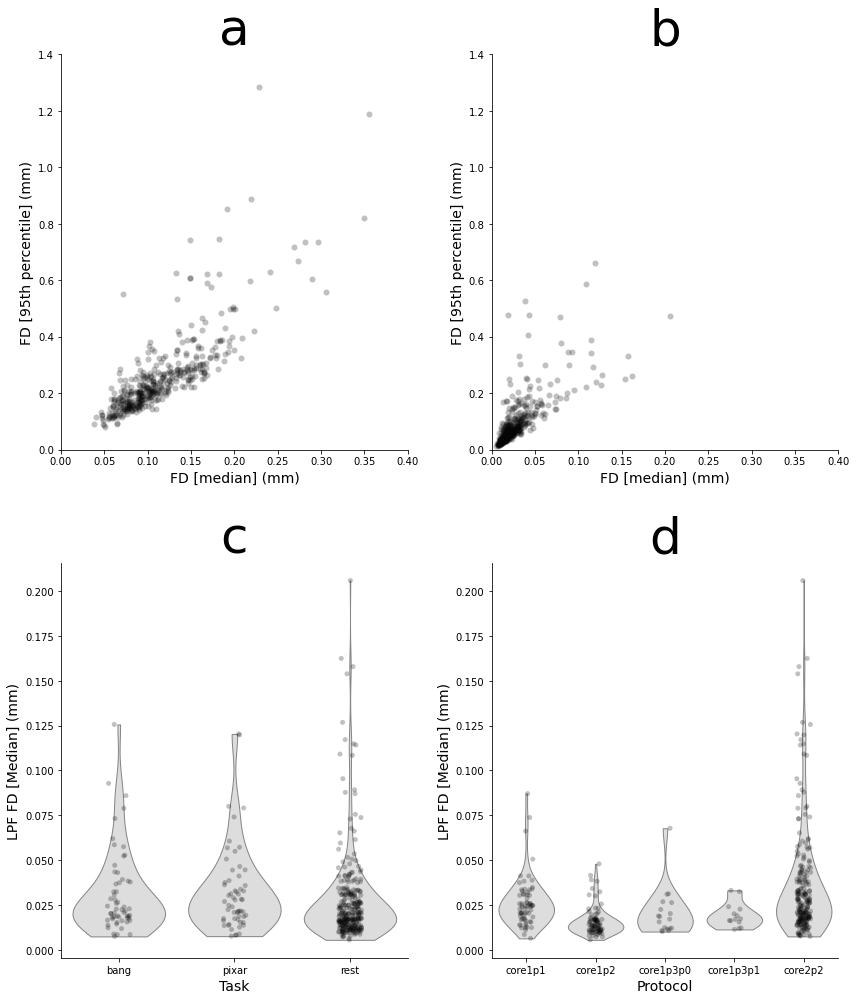

In [6]:
# Set up 2 x 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 14))

#
# Scatter plots of FD_p50 vs FD_p95 over all protocols and tasks
#

sns.scatterplot(
    x='FD_p50',
    y='FD_p95',
    data=fd_stats,
    alpha=0.25,
    color='#050505',
    linewidth=0,
    ax=axs[0, 0]
)

axs[0, 0].set_xlabel('FD [median] (mm)', fontsize=14)
axs[0, 0].set_ylabel('FD [95th percentile] (mm)', fontsize=14)
axs[0, 0].set_xlim((0, 0.4))
axs[0, 0].set_ylim((0, 1.4))

sns.scatterplot(
    x='FD_LPF_p50',
    y='FD_LPF_p95',
    data=fd_stats,
    alpha=0.25,
    color='#050505',
    linewidth=0,
    ax=axs[0, 1]
)

axs[0, 1].set_xlabel('FD [median] (mm)', fontsize=14)
axs[0, 1].set_ylabel('FD [95th percentile] (mm)', fontsize=14)
axs[0, 1].set_xlim((0, 0.4))
axs[0, 1].set_ylim((0, 1.4))

#
# Violin/Strip plots of median filtered FD by Protocol and Task
#

# Median FD By Task
# -----------------

ordered = sorted(moco_df['Task'].unique())

sns.violinplot(
    x='Task',
    y='FD_LPF_p50',
    data=fd_stats,
    cut=0,
    scale='width',
    inner=None,
    linewidth=1,
    color='#DDDDDD',
    saturation=1,
    order=ordered,
    ax=axs[1, 0]
)

sns.stripplot(
    x='Task',
    y='FD_LPF_p50',
    data=fd_stats,
    jitter=True,
    linewidth=0,
    order=ordered,
    color='#050505',
    alpha=0.25,
    ax=axs[1, 0]
)

axs[1, 0].set_ylabel('LPF FD [Median] (mm)')
axs[1, 0].xaxis.label.set_size(14)
axs[1, 0].yaxis.label.set_size(14)


# Median FD By Protocol
# ---------------------

ordered = sorted(moco_df['Protocol'].unique())

sns.violinplot(
    x='Protocol',
    y='FD_LPF_p50',
    data=fd_stats,
    cut=0,
    scale='width',
    inner=None,
    linewidth=1,
    color='#DDDDDD',
    saturation=1,
    order=ordered,
    ax=axs[1, 1]
)

sns.stripplot(
    x='Protocol',
    y='FD_LPF_p50',
    data=fd_stats,
    jitter=True,
    linewidth=0,
    order=ordered,
    color='#050505',
    alpha=0.25,
    ax=axs[1, 1]
)

axs[1, 1].set_ylabel('LPF FD [Median] (mm)')
axs[1, 1].xaxis.label.set_size(14)
axs[1, 1].yaxis.label.set_size(14)

# Leave left axis visible
sns.despine(left=False)

# Subplot letter labels
label_size = 50
label_loc = 'center'
axs[0, 0].set_title('a', fontsize=label_size, loc=label_loc)
axs[0, 1].set_title('b', fontsize=label_size, loc=label_loc)
axs[1, 0].set_title('c', fontsize=label_size, loc=label_loc)
axs[1, 1].set_title('d', fontsize=label_size, loc=label_loc)

fig.tight_layout(h_pad=3, w_pad=3)

plt.savefig('filtered_FD_figure.png', dpi=300, bbox_inches='tight')
plt.show()